In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import networkx as nx
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [405]:
df = pd.read_csv('/content/Web_Attack.csv')
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [406]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [407]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bytes_in,282.0,1.199390e+06,4.149312e+06,40.0,5381.5,13182.0,30833.0,25207794.0
bytes_out,282.0,8.455429e+04,2.549279e+05,44.0,11142.0,13799.5,26279.5,1561220.0
response.code,282.0,2.000000e+02,0.000000e+00,200.0,200.0,200.0,200.0,200.0
dst_port,282.0,4.430000e+02,0.000000e+00,443.0,443.0,443.0,443.0,443.0


In [408]:
df.isnull().sum()

,0
bytes_in,0
bytes_out,0
creation_time,0
end_time,0
src_ip,0
src_ip_country_code,0
protocol,0
response.code,0
dst_port,0
dst_ip,0


In [409]:
df.duplicated().sum()

0

In [410]:
df['src_ip_country_code'].str.isupper() #Checking source ip country code is uppercase or not

,src_ip_country_code
0,True
1,True
2,True
3,True
4,True
...,...
277,True
278,True
279,True
280,True


In [411]:
#converting creation_time, end_time and time to datetime format
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source.meta          2

In [412]:
#Calculate the time difference between creation_time and end_time.
df['Session_Duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df.sample(5)

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,Session_Duration
251,4392,11674,2024-04-26 09:30:00+00:00,2024-04-26 09:40:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 09:30:00+00:00,waf_rule,600.0
228,7994,5754,2024-04-26 09:00:00+00:00,2024-04-26 09:10:00+00:00,165.225.26.101,DE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 09:00:00+00:00,waf_rule,600.0
83,16698,19255,2024-04-26 00:20:00+00:00,2024-04-26 00:30:00+00:00,165.225.209.4,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 00:20:00+00:00,waf_rule,600.0
222,18890,30568,2024-04-26 09:00:00+00:00,2024-04-26 09:10:00+00:00,136.226.67.101,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 09:00:00+00:00,waf_rule,600.0
169,18201558,1170896,2024-04-26 08:00:00+00:00,2024-04-26 08:10:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 08:00:00+00:00,waf_rule,600.0


In [413]:
#Combine bytes_in and bytes_out.
df['total_traffic'] = df['bytes_in'] + df['bytes_out']
df.sample(5)

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,Session_Duration,total_traffic
46,7424,14656,2024-04-25 23:40:00+00:00,2024-04-25 23:50:00+00:00,165.225.26.101,DE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:40:00+00:00,waf_rule,600.0,22080
75,9910,14760,2024-04-26 00:10:00+00:00,2024-04-26 00:20:00+00:00,147.161.131.1,AT,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 00:10:00+00:00,waf_rule,600.0,24670
5,3906,3488,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.77.103,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,7394
45,33268,9986,2024-04-25 23:40:00+00:00,2024-04-25 23:50:00+00:00,136.226.77.103,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:40:00+00:00,waf_rule,600.0,43254
262,38524,42218,2024-04-26 09:40:00+00:00,2024-04-26 09:50:00+00:00,136.226.67.101,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 09:40:00+00:00,waf_rule,600.0,80742


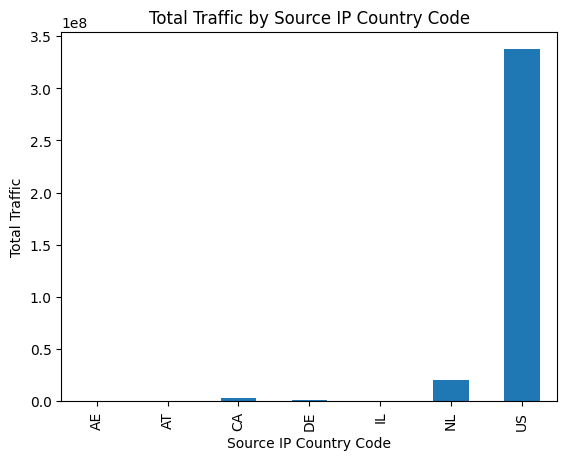

In [414]:
df.groupby('src_ip_country_code')['total_traffic'].sum().plot(kind = 'bar')
plt.xlabel('Source IP Country Code')
plt.ylabel('Total Traffic')
plt.xticks(rotation = 90)
plt.title('Total Traffic by Source IP Country Code')
plt.show()

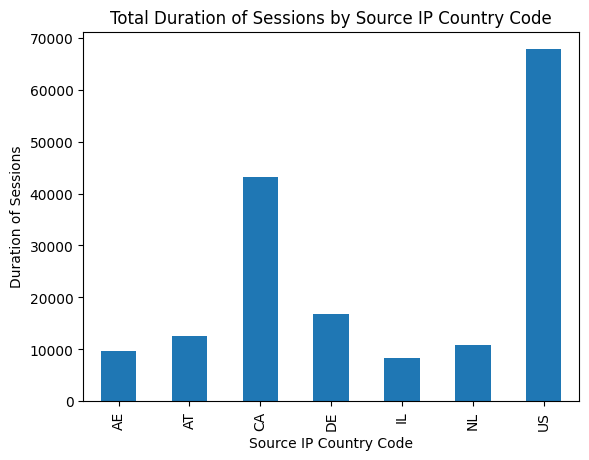

In [415]:
df.groupby('src_ip_country_code')['Session_Duration'].sum().plot(kind = 'bar')
plt.xlabel('Source IP Country Code')
plt.ylabel('Duration of Sessions')
plt.xticks(rotation = 90)
plt.title('Total Duration of Sessions by Source IP Country Code')
plt.show()

In [416]:
#scaling bytes_in, bytes_out,Session_Duration and total_traffic
scaler = StandardScaler()
numerical_features = ['bytes_in', 'bytes_out', 'Session_Duration', 'total_traffic']
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,Session_Duration,total_traffic
0,-0.288219,-0.281223,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,0.0,-0.287850
1,-0.282108,-0.260804,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,0.0,-0.280910
2,-0.282689,-0.279344,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,0.0,-0.282531
3,-0.282197,-0.276161,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,0.0,-0.281883
4,-0.287996,-0.277678,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,0.0,-0.287435


In [417]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[['src_ip_country_code']])
encoded_columns = encoder.get_feature_names_out(['src_ip_country_code'])
print(encoded_columns)

['src_ip_country_code_AE' 'src_ip_country_code_AT'
 'src_ip_country_code_CA' 'src_ip_country_code_DE'
 'src_ip_country_code_IL' 'src_ip_country_code_NL'
 'src_ip_country_code_US']


In [418]:
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=df.index)

df_encoded = pd.concat([df, encoded_df], axis=1)

df_encoded.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,Session_Duration,total_traffic,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
0,-0.288219,-0.281223,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,0.0,-0.287850,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.282108,-0.260804,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,0.0,-0.280910,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.282689,-0.279344,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,0.0,-0.282531,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.282197,-0.276161,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,0.0,-0.281883,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.287996,-0.277678,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,0.0,-0.287435,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [419]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   bytes_in                282 non-null    float64            
 1   bytes_out               282 non-null    float64            
 2   creation_time           282 non-null    datetime64[ns, UTC]
 3   end_time                282 non-null    datetime64[ns, UTC]
 4   src_ip                  282 non-null    object             
 5   src_ip_country_code     282 non-null    object             
 6   protocol                282 non-null    object             
 7   response.code           282 non-null    int64              
 8   dst_port                282 non-null    int64              
 9   dst_ip                  282 non-null    object             
 10  rule_names              282 non-null    object             
 11  observation_name        282 non-null    objec

In [420]:
#Computing the correlation matrix
numerical_columns = df_encoded.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_columns.corr()
correlation_matrix

,bytes_in,bytes_out,response.code,dst_port,Session_Duration,total_traffic,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
bytes_in,1.000000,0.997705,NaN,NaN,NaN,0.999992,-0.070559,-0.081670,-0.166488,-0.095333,-0.065939,-0.006827,0.316015
bytes_out,0.997705,1.000000,NaN,NaN,NaN,0.997963,-0.072452,-0.081777,-0.159587,-0.090001,-0.067630,-0.045641,0.327683
response.code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dst_port,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Session_Duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_traffic,0.999992,0.997963,NaN,NaN,NaN,1.000000,-0.070677,-0.081687,-0.166109,-0.095036,-0.066045,-0.009075,0.316730
src_ip_country_code_AE,-0.070559,-0.072452,NaN,NaN,NaN,-0.070677,1.000000,-0.069568,-0.143607,-0.081429,-0.056055,-0.064040,-0.200546
src_ip_country_code_AT,-0.081670,-0.081777,NaN,NaN,NaN,-0.081687,-0.069568,1.000000,-0.166091,-0.094178,-0.064831,-0.074067,-0.231945
src_ip_country_code_CA,-0.166488,-0.159587,NaN,NaN,NaN,-0.166109,-0.143607,-0.166091,1.000000,-0.194410,-0.133830,-0.152894,-0.478798
src_ip_country_code_DE,-0.095333,-0.090001,NaN,NaN,NaN,-0.095036,-0.081429,-0.094178,-0.194410,1.000000,-0.075885,-0.086695,-0.271493


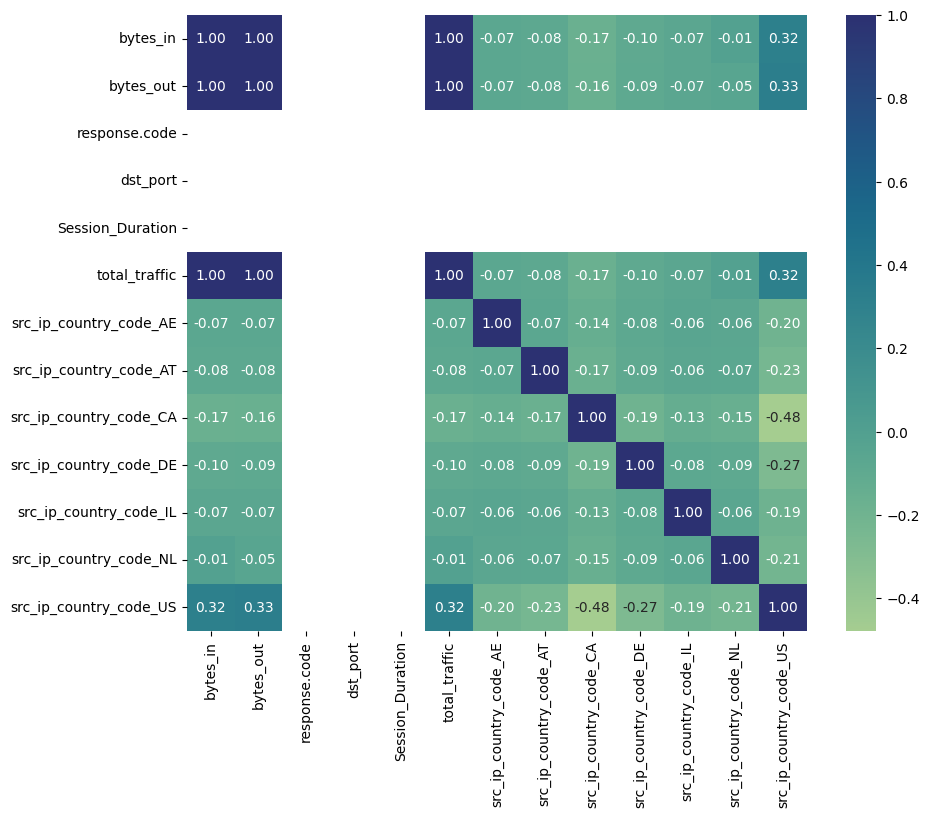

In [421]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='crest');

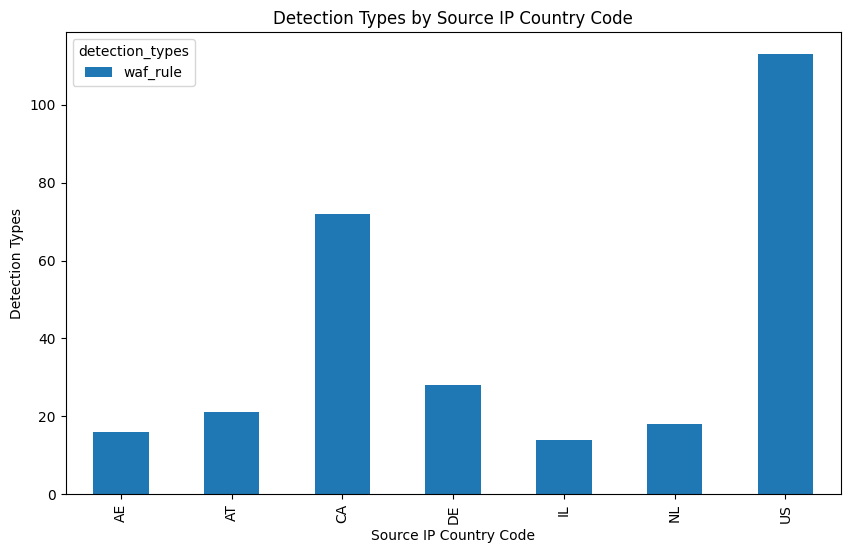

In [422]:
crosstab_result = pd.crosstab(df_encoded['src_ip_country_code'], df_encoded['detection_types'])
crosstab_result.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Source IP Country Code')
plt.ylabel('Detection Types')
plt.title('Detection Types by Source IP Country Code')
plt.show()

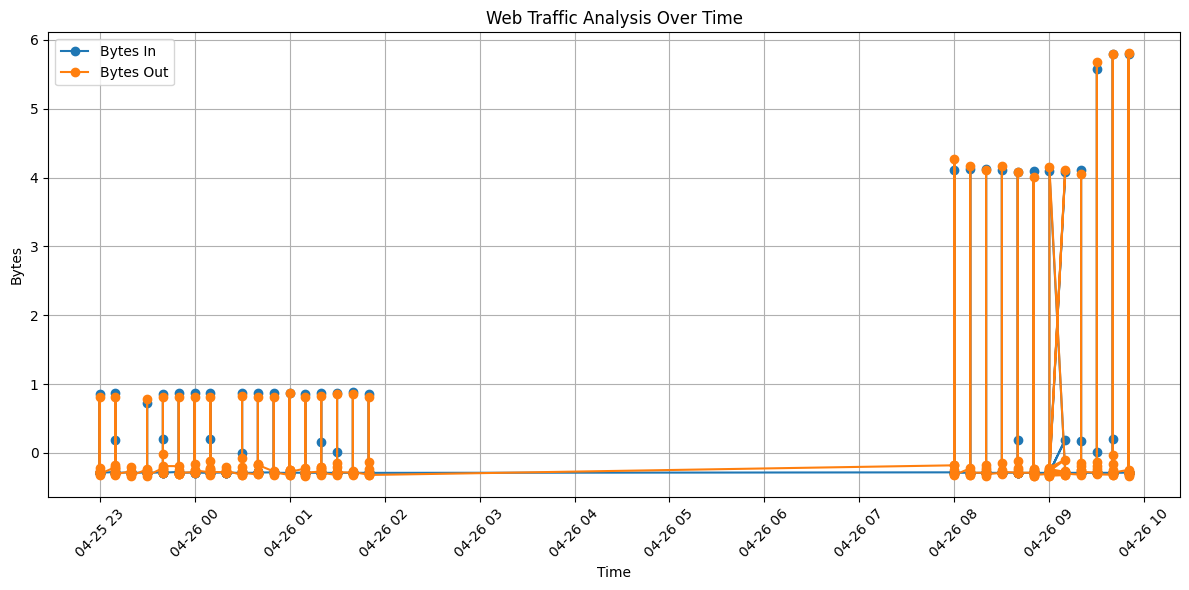

In [423]:
df.set_index('creation_time', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['bytes_in'], label='Bytes In', marker='o')
plt.plot(df.index, df['bytes_out'], label='Bytes Out', marker='o')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

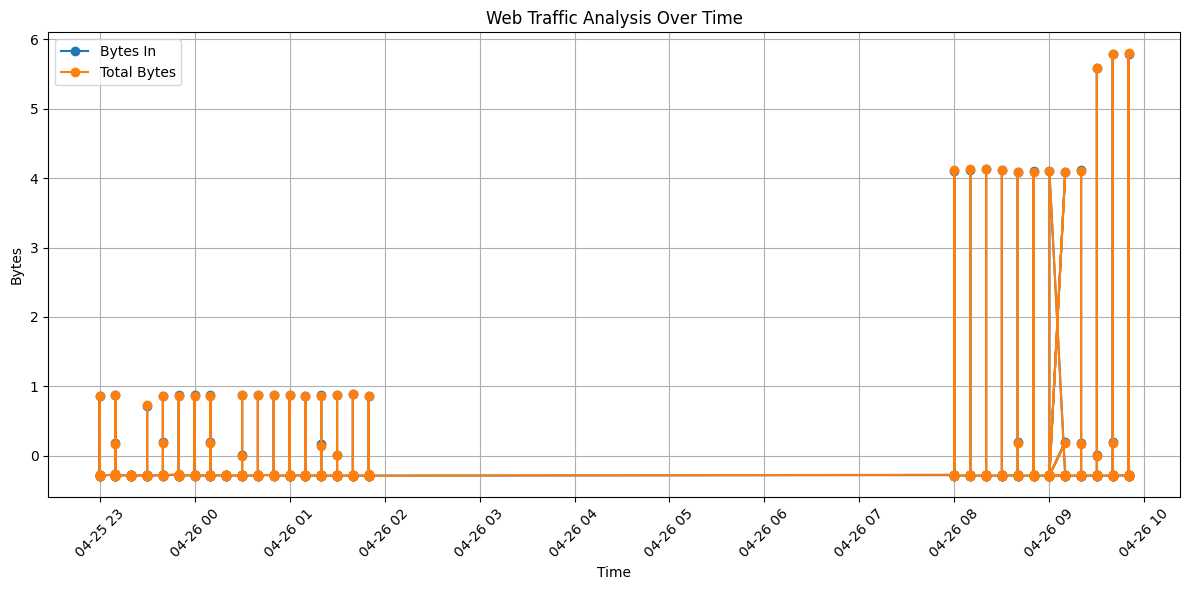

In [424]:
#Web Traffic Analysis between bytes In and total bytes
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['bytes_in'], label='Bytes In', marker='o')
plt.plot(df.index, df['total_traffic'], label='Total Bytes', marker='o')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

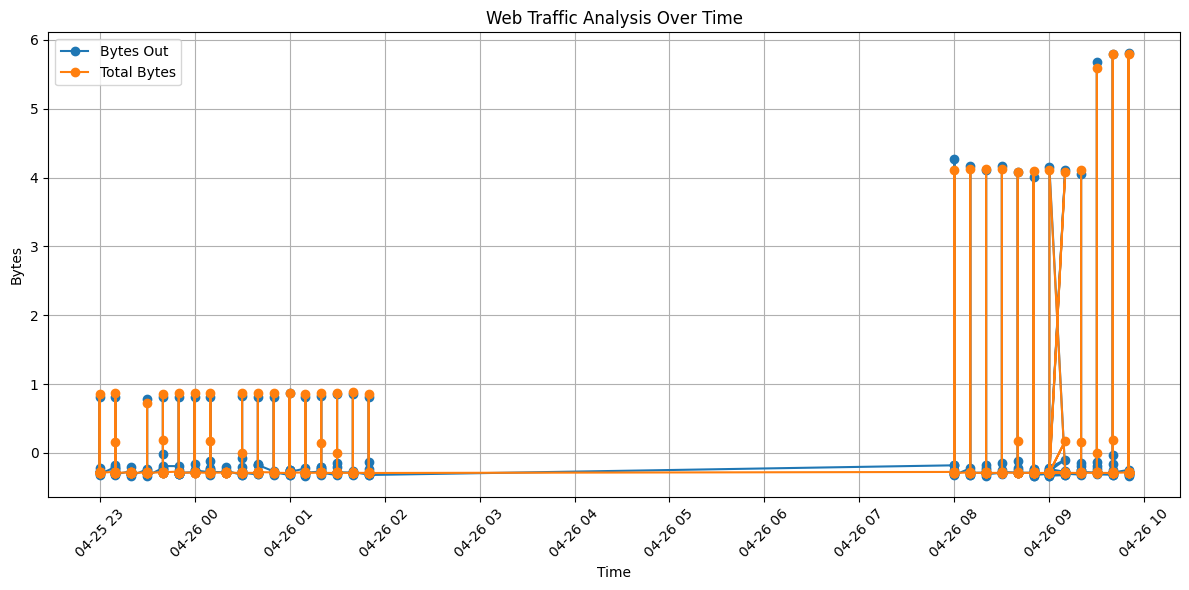

In [425]:
#Web Traffic Analysis between bytes out and total bytes
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['bytes_out'], label='Bytes Out', marker='o')
plt.plot(df.index, df['total_traffic'], label='Total Bytes', marker='o')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

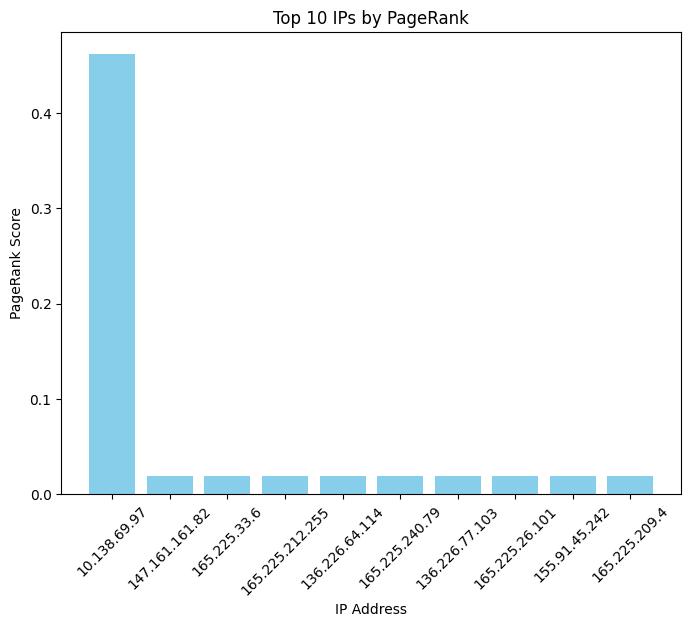

In [426]:
G = nx.Graph()
# Add edges from source IP to destination IP
for idx, row in df.iterrows():
    G.add_edge(row['src_ip'], row['dst_ip'])

# 5. PageRank Plot
pagerank = nx.pagerank(G)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

# Top 10 nodes by PageRank
top_pagerank = sorted_pagerank[:10]
nodes, pagerank_scores = zip(*top_pagerank)

plt.figure(figsize=(8, 6))
plt.bar(nodes, pagerank_scores, color='skyblue')
plt.title('Top 10 IPs by PageRank')
plt.xlabel('IP Address')
plt.ylabel('PageRank Score')
plt.xticks(rotation=45)
plt.show()


Given the structure of your dataset, Selecting the following columns:

**bytes_in:** Represents the incoming bytes, which can indicate unusual spikes or drops in traffic.

**bytes_out:** Represents the outgoing bytes, which can also show anomalies in traffic patterns.

**Session_Duration:** Duration of the session can reveal irregularities in user engagement or session length.

**total_traffic:** Total traffic can provide insights into overall patterns.

In [427]:
features = df_encoded[['bytes_in', 'bytes_out', 'Session_Duration', 'total_traffic']]

X_train, X_test = train_test_split(features, test_size=0.2, random_state=42)

In [428]:
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_train)

IsolationForest(contamination=0.1, random_state=42)

In [429]:
y_pred_test = model.predict(X_test)

In [430]:
y_pred_test

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1])

In [431]:
y_pred_test = [1 if x == -1 else 0 for x in y_pred_test]  # 1 for anomalies, 0 for normal
y_pred_test

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [432]:
num_anomalies = sum(y_pred_test)
num_normal = len(y_pred_test) - num_anomalies

print(f'Number of anomalies detected: {num_anomalies}')
print(f'Number of normal points: {num_normal}')

Number of anomalies detected: 5
Number of normal points: 52


In [433]:
y_true = np.random.choice([0, 1], size=len(y_pred_test), p=[0.9, 0.1])  # Simulated ground truth

In [434]:
accuracy = accuracy_score(y_true, y_pred_test)
conf_matrix = confusion_matrix(y_true, y_pred_test)
class_report = classification_report(y_true, y_pred_test)

print("Model Accuracy: ",accuracy)
# Print the classification report
print("Classification Report:")
print(class_report)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Model Accuracy:  0.8245614035087719
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        52
           1       0.00      0.00      0.00         5

    accuracy                           0.82        57
   macro avg       0.45      0.45      0.45        57
weighted avg       0.82      0.82      0.82        57

Confusion Matrix:
[[47  5]
 [ 5  0]]


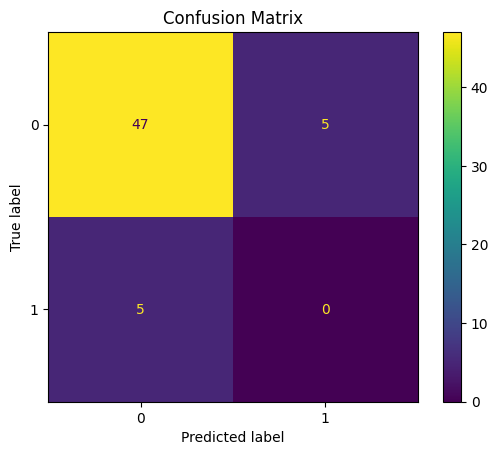

In [435]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.title('Confusion Matrix')
plt.show()

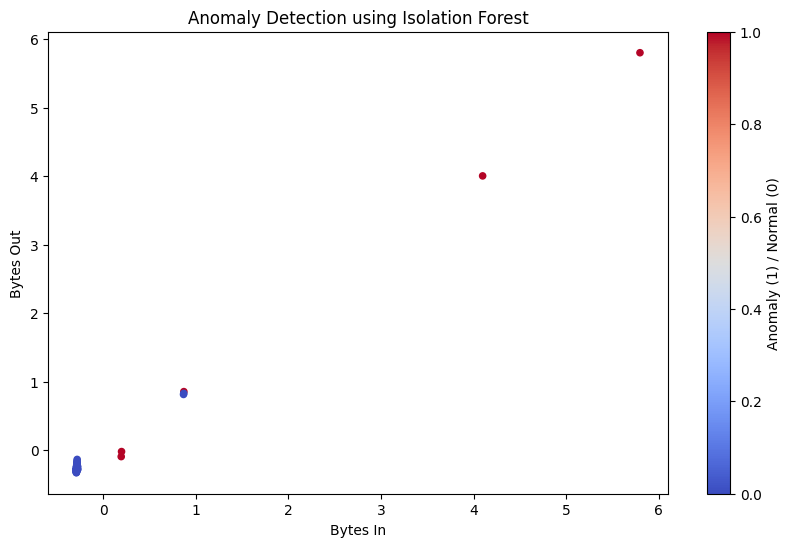

In [436]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test['bytes_in'], X_test['bytes_out'], c=y_pred_test, cmap='coolwarm', s=20)
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Bytes In')
plt.ylabel('Bytes Out')
plt.colorbar(label='Anomaly (1) / Normal (0)')
plt.show()